# **Attention Mechanism**

Luong et al., (2015) Effective Approaches to Attention-based Neural Machine Translation
https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1


Attention Score 계산
Decoder 마지막 은닉상태와 Encoder의 모든 입력단계의 은닉상태들과 내적을 계산한다.



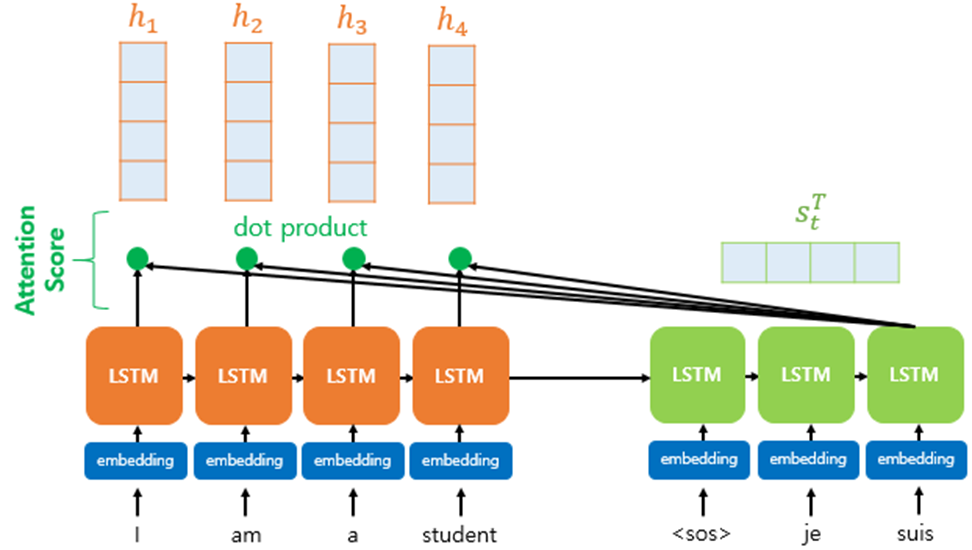

# **Attention Mechanism**

Attention Score 계산 의미


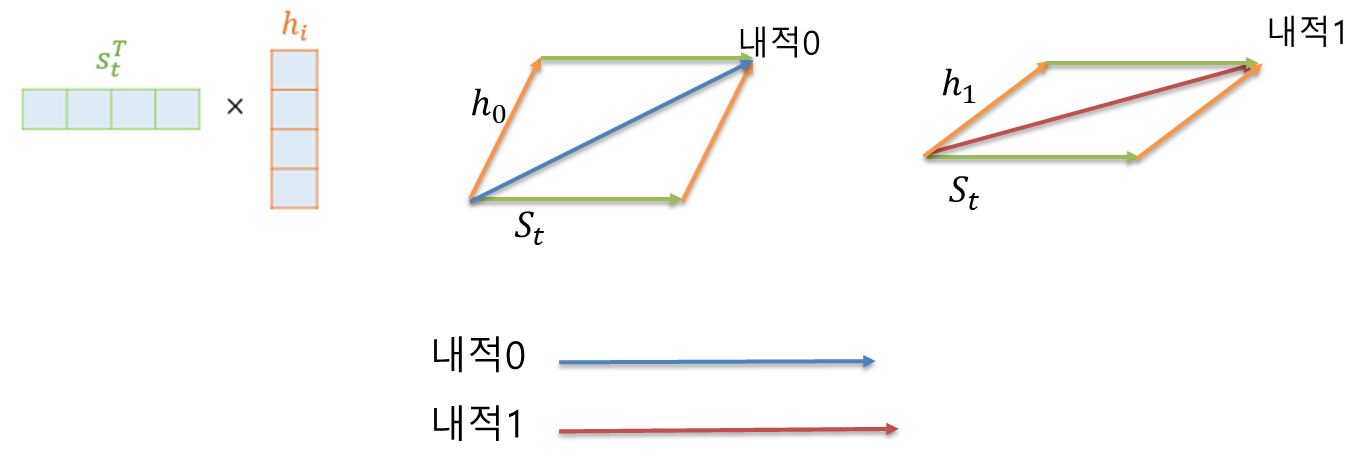

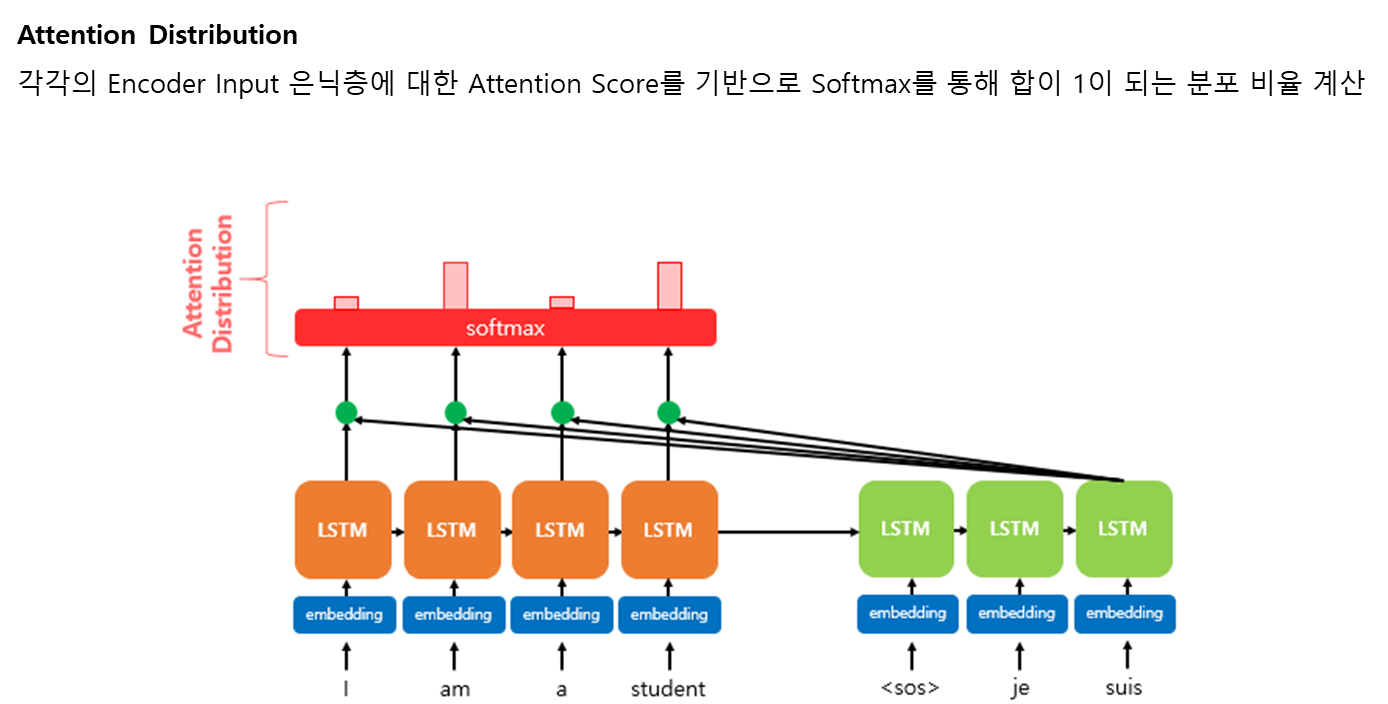

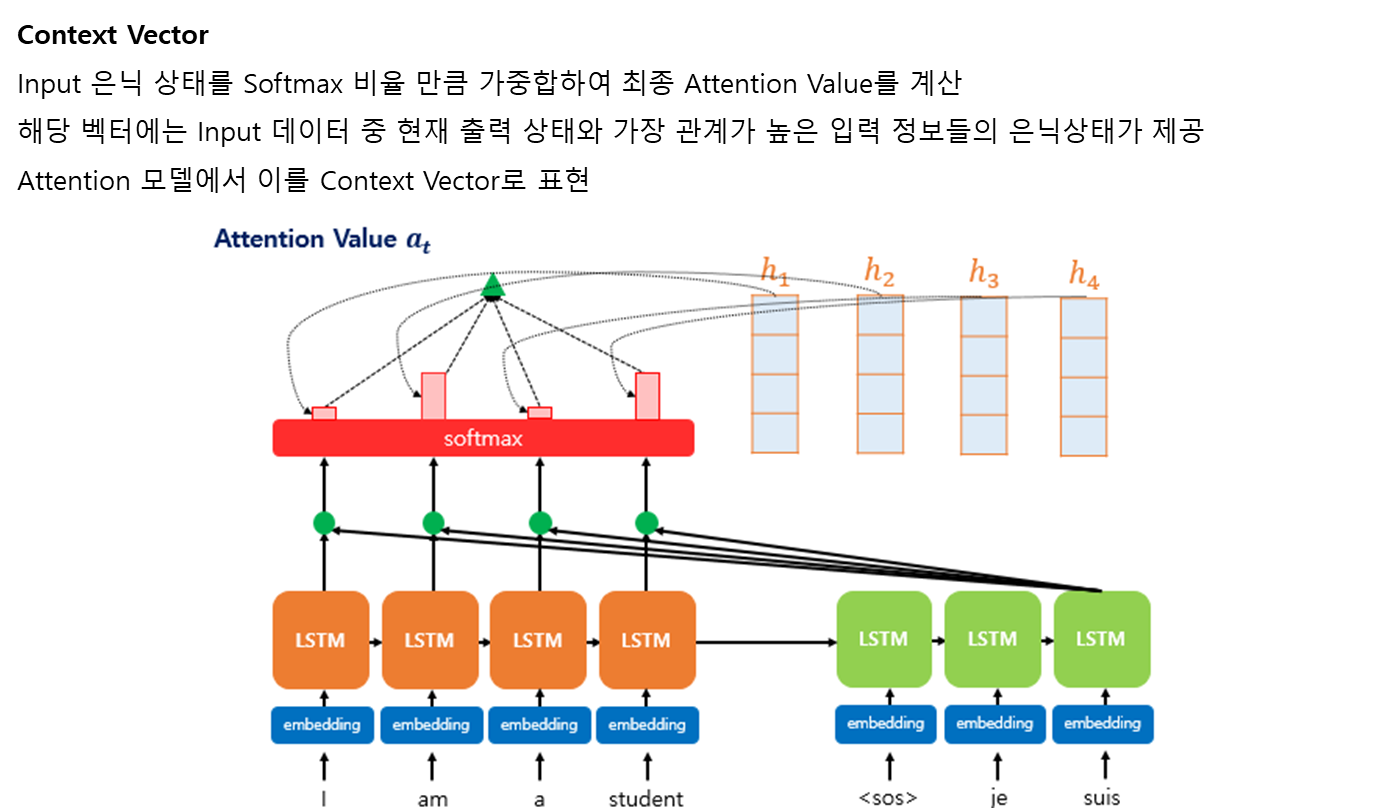

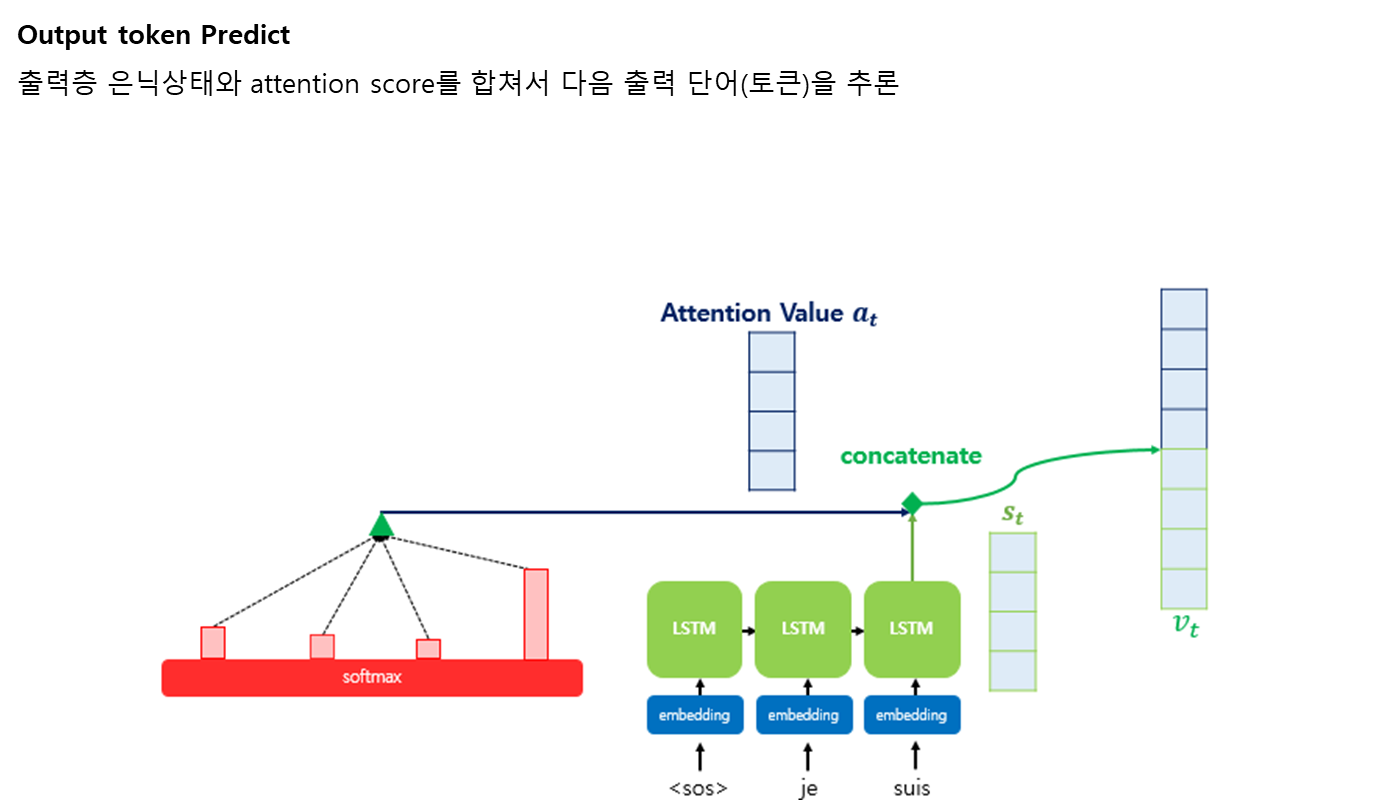

# **Attention is all you need (NIPS 2017) = Transformer**

논문 : https://arxiv.org/abs/1706.03762

소스 : https://github.com/ukairia777/tensorflow-transformer  


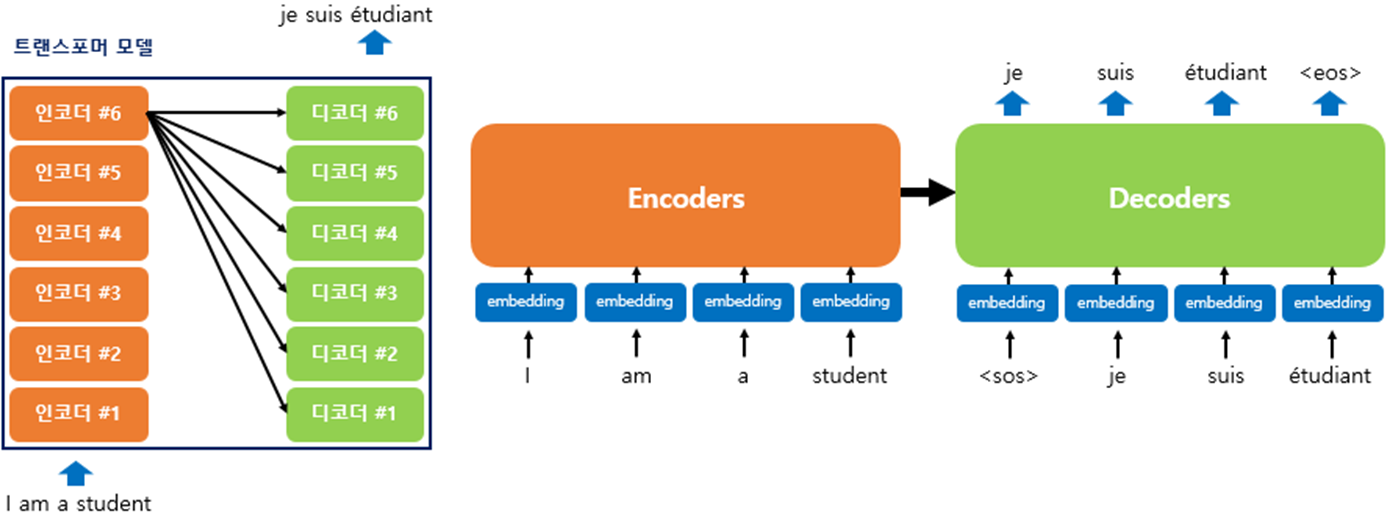

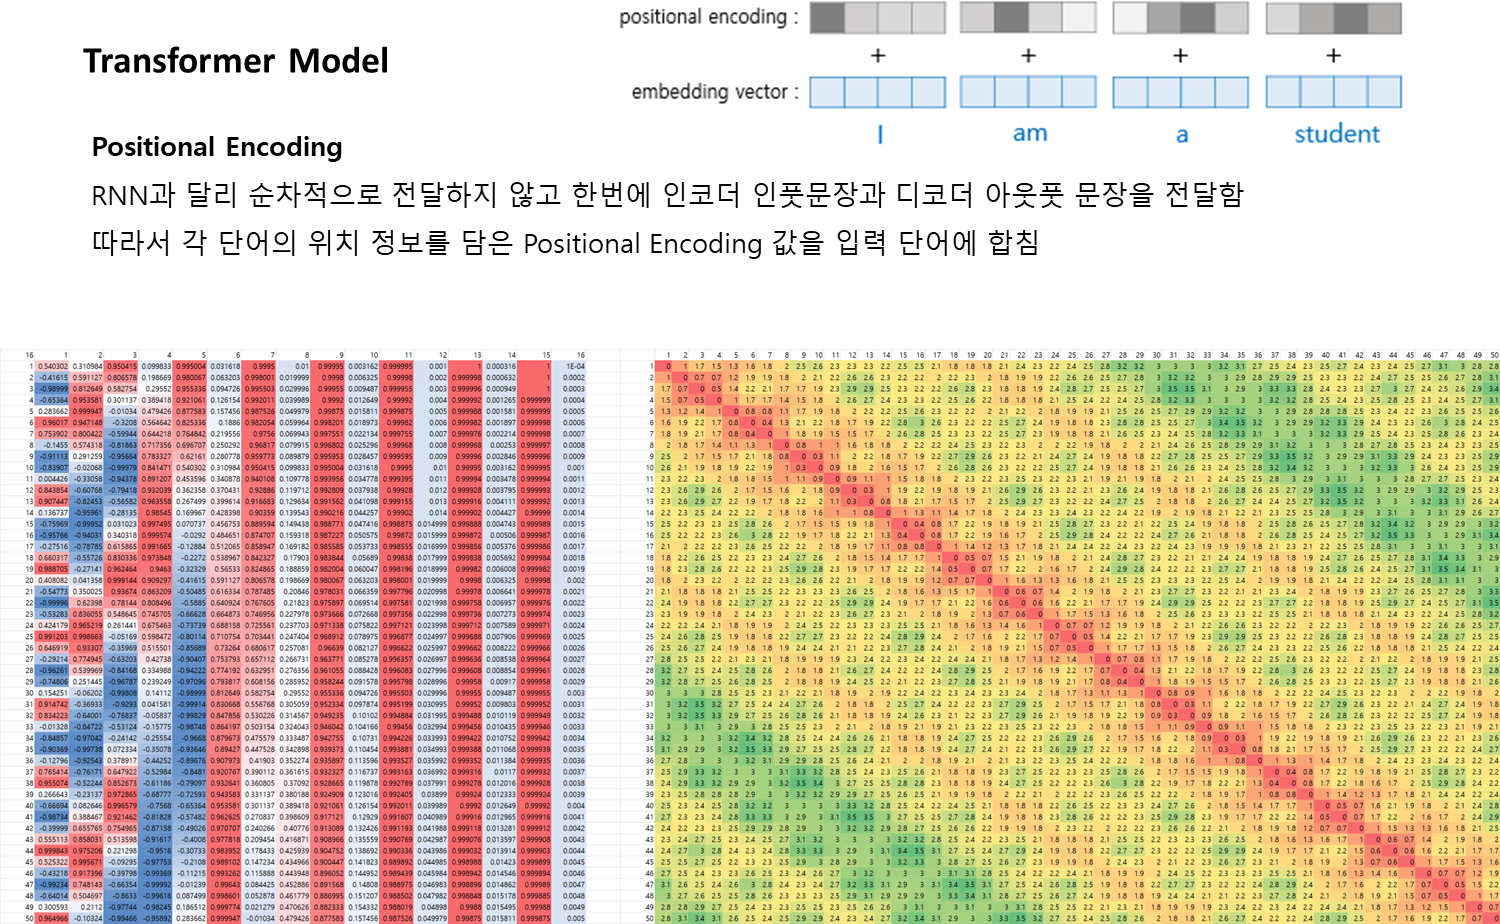

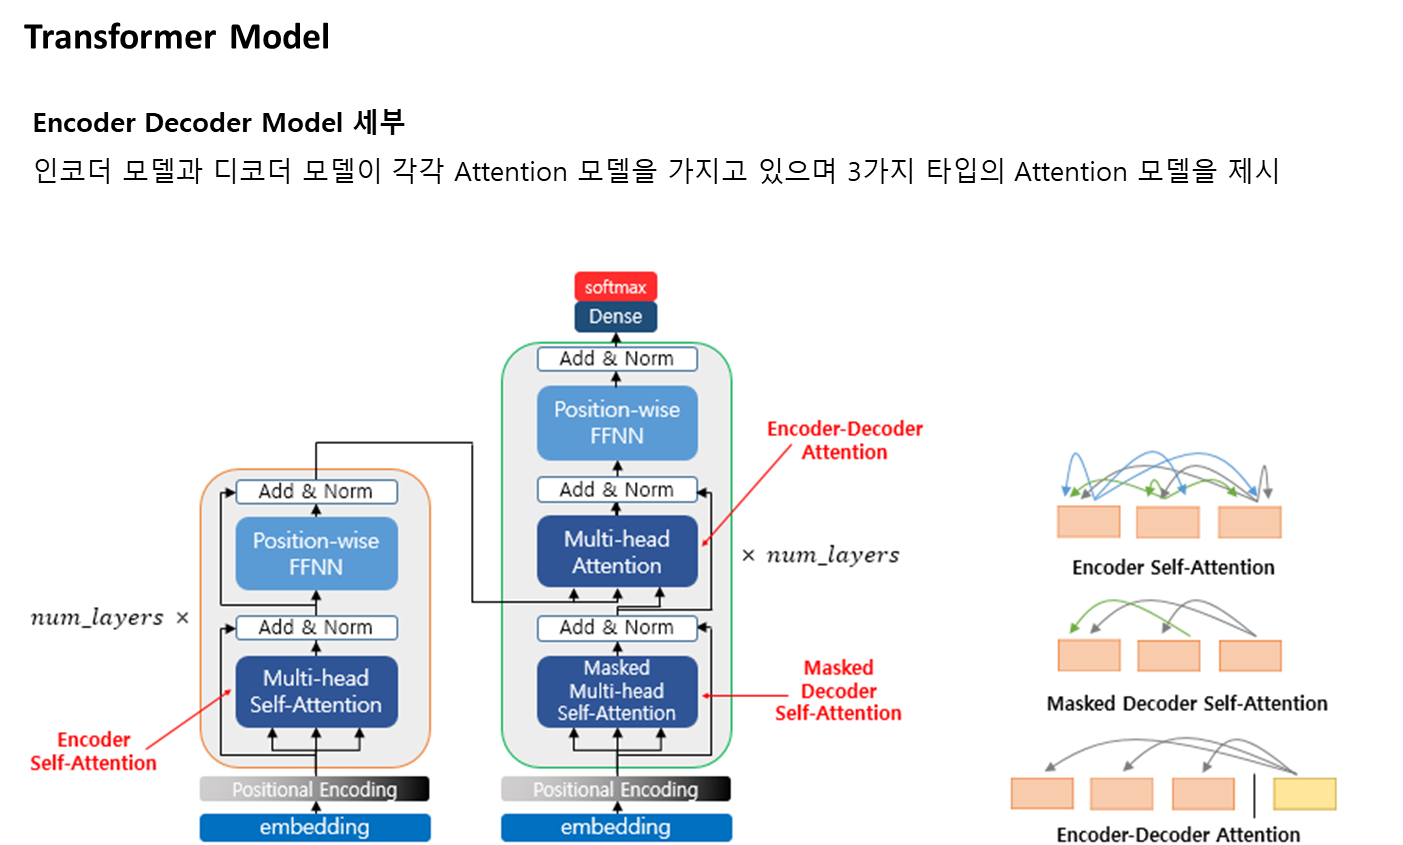

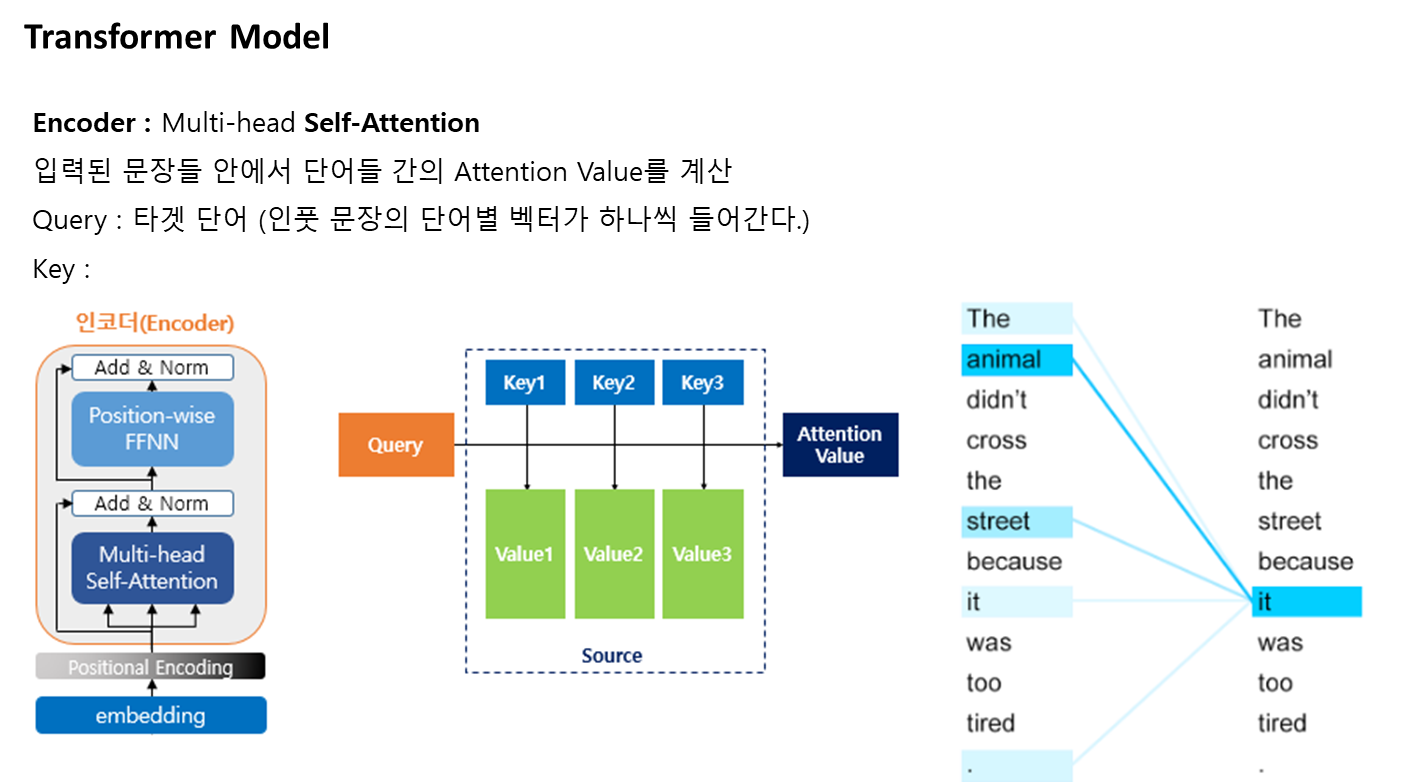

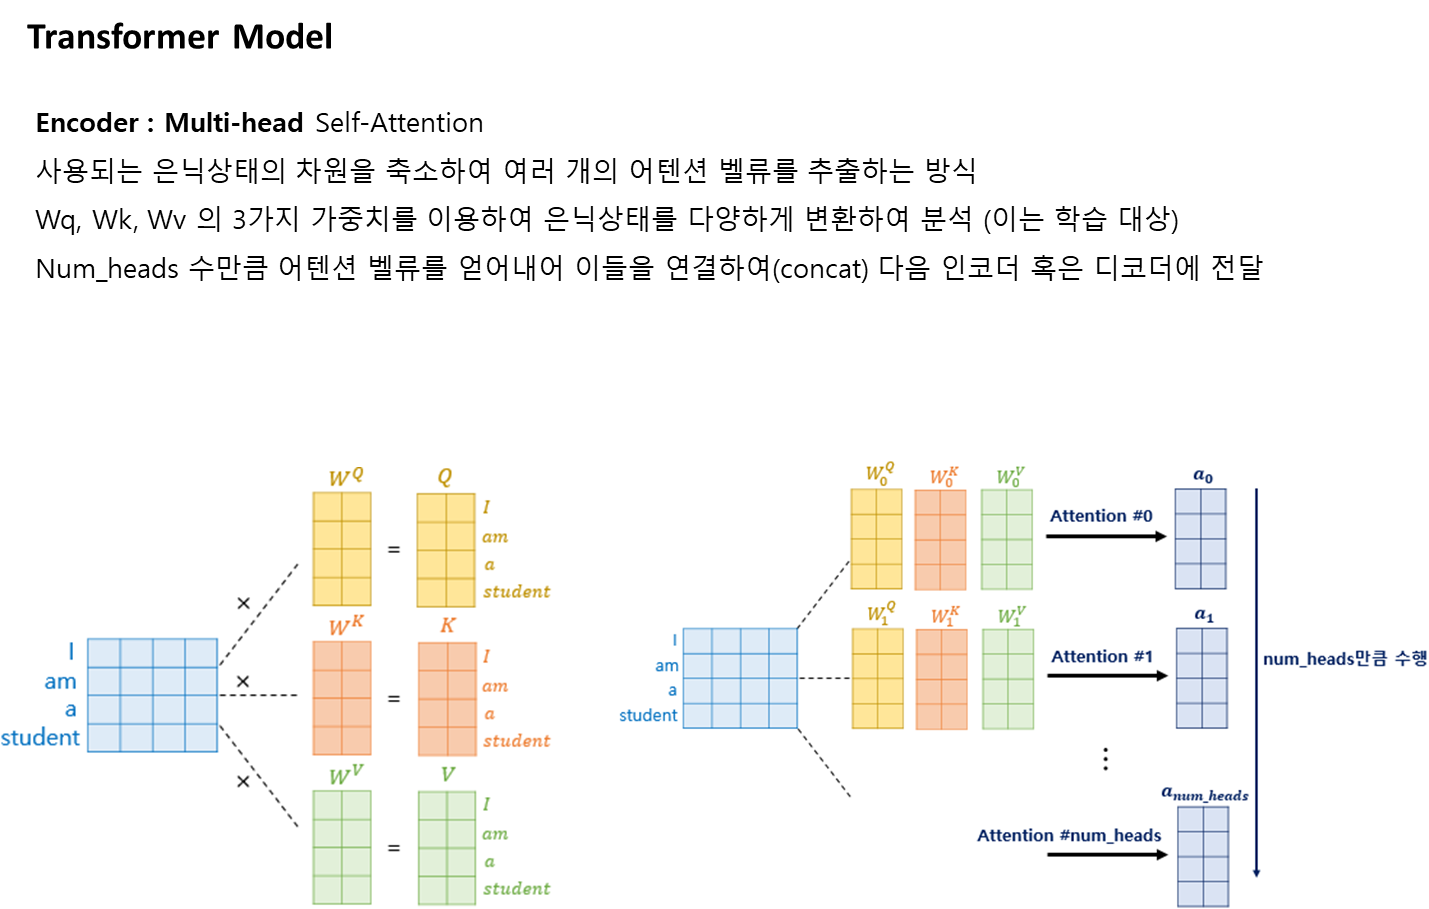

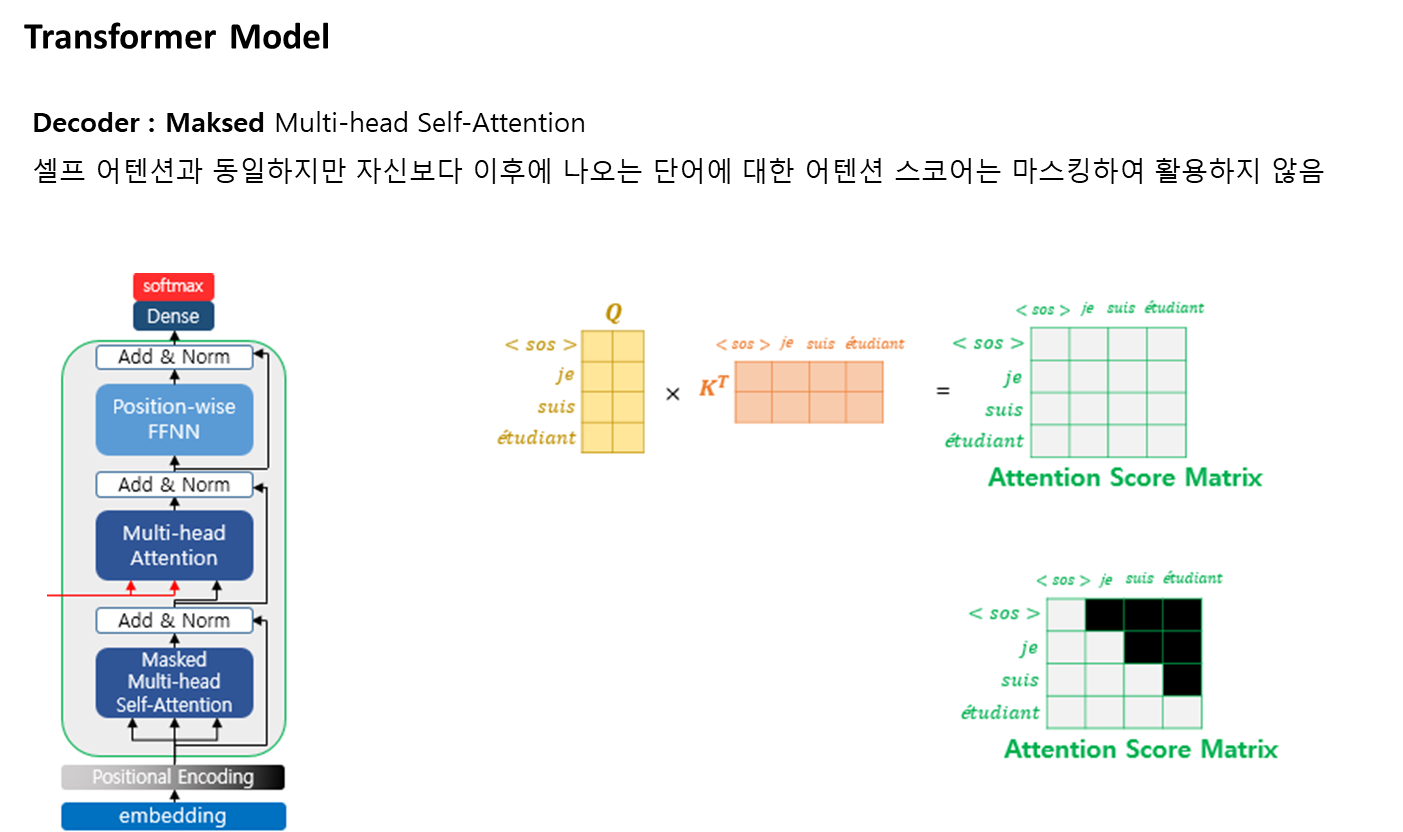

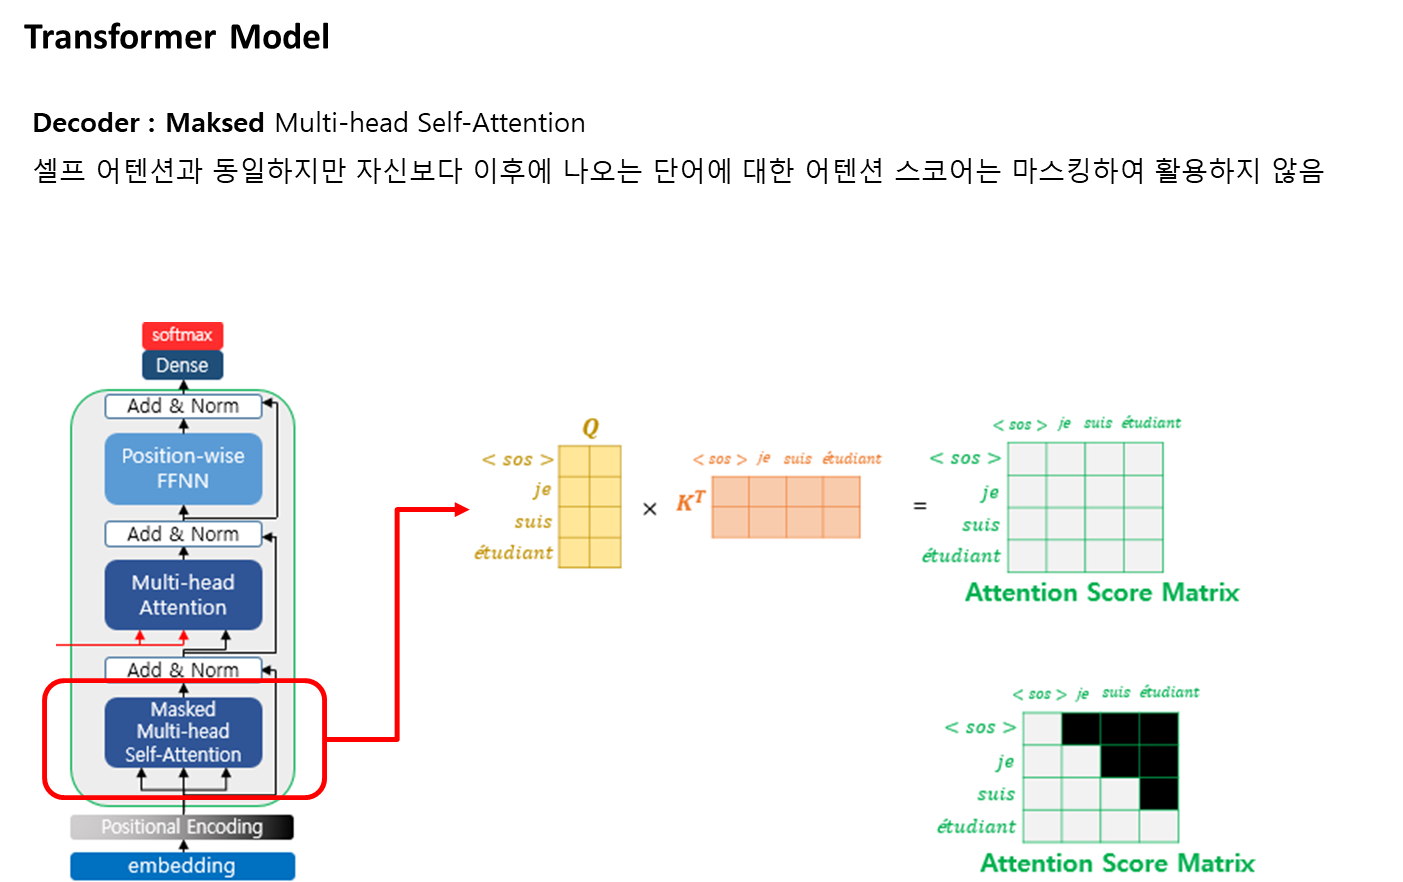

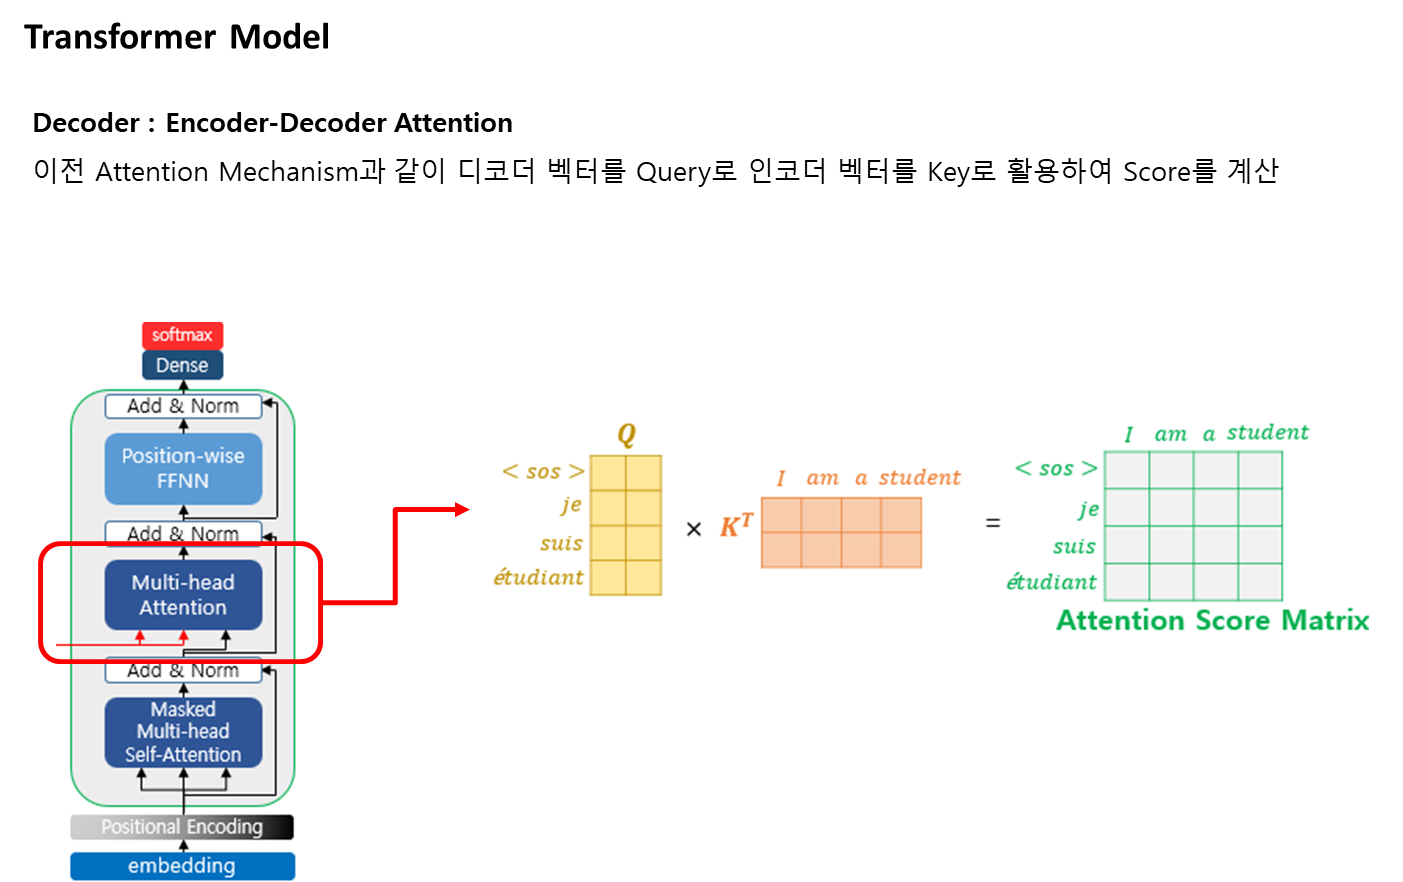

# **https://pypi.org/project/transformers/**

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
import torch

model_name = "Helsinki-NLP/opus-mt-ko-en"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)


In [ ]:
# prompt: input_ids 를 다시 한글로 변환해주고 각 토큰 인덱스와 매칭되는 한글을 표시

# 예시 입력
input_text = "한국은 아름다운 나라입니다."
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# input_ids를 한글 토큰으로 변환
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# 각 토큰 인덱스와 매칭되는 한글 출력
for i, token in enumerate(tokens):
    print(f"Index: {i}, Token: {token},  Decoded Text: {tokenizer.decode([input_ids[0][i]])}")

In [ ]:

# 번역 실행
translated_ids = model.generate(input_ids, max_length=50)
translation = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
print(translation)


In [ ]:
# prompt: 한글 문장을 입력하면 모델을 이용해 영어로 번역하여 답변하는 챗봇을 구현해줘
def translate_korean_to_english(korean_text):
    """
    한국어 문장을 입력받아 영어로 번역하는 함수
    """
    try:
        input_ids = tokenizer.encode(korean_text, return_tensors="pt")
        translated_ids = model.generate(input_ids, max_length=50)
        translation = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
        return translation
    except Exception as e:
        print(f"번역 중 오류 발생: {e}")
        return "번역에 실패했습니다."


while True:
    korean_input = input("한국어 문장을 입력하세요 (종료하려면 'exit' 입력): ")
    if korean_input.lower() == "exit":
        break

    english_translation = translate_korean_to_english(korean_input)
    print(f"번역 결과: {english_translation}")

In [ ]:
# prompt: model 구조 출력

model

In [ ]:

def get_embedding_for_token(model, token, tokenizer):
    """
    Gets the embedding for a given token from the model's embedding layer.
    """
    try:
        # Tokenize the input token
        token_ids = tokenizer.encode(token, return_tensors="pt")

        # Check if the token was successfully tokenized
        if token_ids.shape[1] == 0:
          print(f"Token '{token}' could not be tokenized.")
          return None

        # Get the token ID
        token_index = token_ids[0][0]

    except Exception as e:
        print(f"Error processing token '{token}': {e}")
        return None

    # Get the embedding layer
    embedding_layer = model.get_input_embeddings()

    # Get the embedding
    embedding = embedding_layer(token_index)

    return embedding


# Example usage:
token_to_find = "남자"
embedding = get_embedding_for_token(model, token_to_find, tokenizer)
if embedding is not None:
    print(f"Embedding for '{token_to_find}':\n{embedding}")


In [ ]:
# prompt: "대한민국"과 "한국", "우리나라", "남한", "북한"의 임베딩을 구하고 상호 cos유사도를 계산하요 표러 표시

import pandas as pd
import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# Sample embeddings (replace with actual embeddings from your model)
embeddings = {
    "남자": get_embedding_for_token(model, "남자", tokenizer),
    "여자": get_embedding_for_token(model, "여자", tokenizer),
    "왕자":  get_embedding_for_token(model, "왕자", tokenizer),
    "공주":  get_embedding_for_token(model, "공주", tokenizer),
    "남성":  get_embedding_for_token(model, "남성", tokenizer),
    "딸":  get_embedding_for_token(model, "딸", tokenizer),
    "아들":  get_embedding_for_token(model, "아들", tokenizer),
    "왕":  get_embedding_for_token(model, "왕", tokenizer),
    "여왕":  get_embedding_for_token(model, "여왕", tokenizer),
}


# Process other embeddings
for word, emb in embeddings.items():
    if emb is not None:
        emb_np = emb.cpu().detach().numpy()
        embeddings[word] = emb_np


In [ ]:
# prompt: get_embedding_for_token(model, "남자", tokenizer) 값에서 get_embedding_for_token(model, "여자", tokenizer) 까지의 방향과 거리를 계산하고 get_embedding_for_token(model, "왕자", tokenizer) 값에 그 방향과 거리를 더하면 나올 수 있는 글자를 찾자

import numpy as np

# Calculate the direction and distance between "남자" and "여자"
man_embedding = embeddings["남자"]
woman_embedding = embeddings["여자"]

if man_embedding is not None and woman_embedding is not None:
    direction = woman_embedding - man_embedding
    distance = np.linalg.norm(direction)

    # Apply the direction and distance to "왕자"
    prince_embedding = embeddings["왕자"]
    if prince_embedding is not None:
        new_embedding = prince_embedding + direction

        # Find the closest word in the vocabulary (This part needs refinement)
        min_distance = float('inf')
        closest_word = None

        for word, emb in embeddings.items():
            if emb is not None and word not in ["왕자", "남자", "여자"]:  # Exclude the original words
                dist = np.linalg.norm(new_embedding - emb)
                if dist < min_distance:
                    min_distance = dist
                    closest_word = word
                print(word + " : " + str(dist))

        if closest_word:
          print(f'The word closest to the calculated embedding is: {closest_word}')
        else:
          print("No close word found in the provided embeddings.")


    else:
        print("Embedding for '왕자' not found.")
else:
    print("Embeddings for '남자' or '여자' not found.")

In [ ]:
# import torch
# from transformers import MarianMTModel, MarianTokenizer
import seaborn as sns
import matplotlib.pyplot as plt


# Input text
input_text = "어제 공원 갔는데 거기 사람 많더라"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Forward pass through the encoder only to get attention weights
encoder_outputs = model.get_encoder()(input_ids, output_attentions=True)
attention = encoder_outputs.attentions  # Encoder attention

# Choose the attention from the last layer (you can change to any layer)
last_layer_attention = attention[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]

# Average over all heads to get a single attention map
average_attention = torch.mean(last_layer_attention, dim=1).squeeze(0).detach().numpy()

# Convert input IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Convert input IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Print attention values as text
print("Self-Attention Values (Last Encoder Layer):")
for i, query_token in enumerate(tokens):
    print(f"Query Token: {query_token}")
    for j, key_token in enumerate(tokens):
        print(f"  Key Token: {key_token}, Attention Value: {average_attention[i, j]:.4f}")
    print()

In [ ]:
# prompt: 디코더에서 단어가 하나씩 생성되게 출력하면서 attention score를 이용해서 input 문장에서 attention 단어를 같이 출력


# Input text
input_text = "어제 공원 갔는데 거기 사람 많더라"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Get encoder outputs with attention weights
encoder_outputs = model.get_encoder()(input_ids, output_attentions=True)
attention = encoder_outputs.attentions  # Encoder attention

# Average over all heads
average_attention = torch.mean(attention[-1], dim=1).squeeze(0)

# Convert input IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Decoder's first token
decoder_start_token_id = model.config.decoder_start_token_id
decoder_input_ids = torch.tensor([[decoder_start_token_id]])

generated_tokens = []

# Generate tokens one by one
for _ in range(20): # Limit to 20 tokens for demonstration
    decoder_outputs = model.get_decoder()(
        input_ids=decoder_input_ids,
        encoder_hidden_states=encoder_outputs.last_hidden_state,
        output_attentions=True,
    )

    # Get cross-attention from the last decoder layer
    cross_attention = decoder_outputs.cross_attentions[-1]
    average_cross_attention = torch.mean(cross_attention, dim=1).squeeze(0)

    # Get attention for the current decoder token
    decoder_attention = average_cross_attention[-1]  # Last token in decoder sequence

    # Find the index of the most attended encoder token
    most_attended_index = torch.argmax(decoder_attention)
    most_attended_token = tokens[most_attended_index]

    # Generate next token
    next_token_logits = model.lm_head(decoder_outputs.last_hidden_state)
    next_token_id = torch.argmax(next_token_logits, dim=-1)[:, -1]

    generated_tokens.append(tokenizer.decode(next_token_id))

    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0)], dim=1)


    # Print output with attention
    print(f"Generated Token: {tokenizer.decode(next_token_id)} | Attention: {most_attended_token}")

    if next_token_id == tokenizer.eos_token_id:
        break